# NTDS: Data parsing and preparation Notebook

This notebook will consists of data preparation. \
First we are going to clean the dataframe by splitting/parsing the more infos columns the best we can so that we can obtain the following information about a song from the Genius requests:
1. names of all the songwritters
2. names of all the producers
3. names of the labels

Note that the majority of songs we obtained are so that no informations are recoverable. Thus we consider that the artist both wrote and produced his song. Also we consider him as an independent artist until we find if he worked with a label for another song. 

Once this dataframe created, we can start doing some study about our dataset which we will explain later on in this notebook

In [1]:
import pandas as pd
import numpy as np
import re

## Creation of the cleaned dataframe

First we load the dataframe we have created from the Kaggle dataset on Spotify songs and with the respective Genis informations.

In [2]:
# if already created
artists_writers_df = pd.read_pickle("artists_writers_df.pkl")
artists_writers_df = artists_writers_df.drop_duplicates(['track_name', 'artist'])

Here is what the dataframe looks like at the moment:

In [3]:
artists_writers_df.head(10)

,track_name,artist,genre,popularity,more_infos
0,Be Without You,Mary J. Blige,R&B,65,"[Strings,artists:[{_type:artist,api_path:/arti..."
1,Desperado,Rihanna,R&B,63,"[Distributor,artists:[{_type:artist,api_path:/..."
2,Ice On My Baby,Yung Bleu,R&B,62,"[Video,overlay_compatible_image_url:https://im..."
3,Heaven Falls / Fall on Me,Surfaces,R&B,61,[]
4,Love Myself,Olivia O'Brien,R&B,68,"[Video,overlay_compatible_image_url:https://im..."
5,Needs,ELHAE,R&B,61,[]
6,Make It Out Alive,Nao,R&B,64,"[Mastering Engineer,artists:[{_type:artist,api..."
7,Seigfried,Frank Ocean,R&B,66,"[news,overlay_compatible_image_url:https://ima..."
8,Roll In Peace,Layton Greene,R&B,60,"[feature,overlay_compatible_image_url:https://..."
9,You Make Me Wanna...,Usher,R&B,69,"[news,overlay_compatible_image_url:https://ima..."


Now that the dataframe is loaded, we can start working and the creation of the new one. To do this we defined the following function: create_final_dataframe(df). \
This function just takes care of filling a new dataframe with clean data and also to do all the parsing of the informations obtained from Genius. Note that the parsing was facilated from the fact that some indicators where already present in the text obtained after a request. But, for less well known songs, note that the data is far less wel represented and thus that we can loose lots informations when parsing.

Also when you go on Genius, some songs that have no producers in the result obtained from the request can have one on the website on the top of the page. Thus we are either going to drop this songs, or just consider that the artists do all the work by themselves.

In [61]:
def format_string(string):
    
    '''
    Given a string, normalize its format using regex expression. (note we filled this function step by step as errors where
    seen in latter on studies)
    INPUT: string: string to be modified
    OUTPUT: string: string modified
    '''
    
    string = re.sub("’", "'", string)
    string = re.sub(r'[^\x00-\x7F]+',' ', string)
    if string[0] == ' ':
        string = string[1:]
    string = string.lower()
    
    return string

def create_final_dataframe(df):
    
    '''
    Function that allows the parsing of the infos we obtained about our songs
    INPUT: dataframe containing the joint informations from the Spotify dataset of songs and teh Genius API requests
    OUPUT: new, well formated dataframe
    '''
    
    columns_list = ['track_name','artist_name','songwriters','producers','labels','genre','popularity']
    new_df = pd.DataFrame(columns=columns_list)
    
    
    for row in df.iterrows():
        artist_name = format_string(row[1]['artist'])
        track_name = row[1]['track_name']
        popularity = row[1]['popularity']
        genre = row[1]['genre']
        writters = []
        labels = []
        producers = []
        
        if len(row[1]['more_infos']) != 0:
            for el in row[1]['more_infos']:
                # writers of the songs
                if 'writer_artists' in str(el):
                    for name in str(str(el).split('writer_artists')[1]).split('name:')[1:]:
                        writters.append(format_string(str(name).split(',')[0]))
                # we use this second condition to be sure to miss no writters in specific cases
                if 'artists' in str(el) and 'news' not in str(el): 
                    if(str(el).split(':')[0] == 'Lyricist,artists'):
                        for name in str(el).split('name:')[1:]:
                            writters.append(format_string(str(name).split(',')[0]))
                # We assume that if no writters ar mentionned that the artist wrote the song
                if len(writters) == 0:
                    writters = [artist_name]

                # labels of the songs
                if 'Label,artists' in str(el):
                    for name in str(str(el).split('Label,artists')[1]).split('}]')[0].split('name:')[1:]:
                        labels.append(format_string(str(name).split(',')[0]))

                # producers of the song
                if 'producer_artists' in str(el):
                    for name in str(str(el).split('producer_artists')[1]).split('}]')[0].split('name:')[1:]:
                        producers.append(format_string(str(name).split(',')[0]))
                
            
            # we assume that if no label is mentionned that the artist is independent
            if len(labels) == 0:
                labels = ['independent']
                
            # we assume that if no producer is mentionned that the artist produced the song himself
            if len(producers) == 0:
                    producers = [artist_name]

            writters = np.unique(writters)
            producers = np.unique(producers)
            new_row = pd.DataFrame([[track_name, artist_name, writters, producers, \
                                     labels, genre, popularity]], columns=columns_list)
            new_df = new_df.append(new_row, ignore_index=True)
        
    return new_df

In [62]:
final_dataframe = create_final_dataframe(artists_writers_df)

Below you can see what our final dataframes looks like

In [63]:
final_dataframe.head(2)

,track_name,artist_name,songwriters,producers,labels,genre,popularity
0,Be Without You,mary j. blige,"[bryan-michael cox, jason perry, johnt austin...",[bryan-michael cox],[geffen records],R&B,65
1,Desperado,rihanna,"[banks, d. rachel, james fauntleroy, mick schu...","[james fauntleroy, kuk harrell, mick schultz]","[westbury road, roc nation]",R&B,63


## Study of the data

In this part we are going to do some study of our dataset. This means we are going to plot who are the most presents artists in our dataframe, which are the labels the most represented, are the labels genre specific or not, which producers are the most represented, etc...

In [64]:
import seaborn as sns
import collections
import operator
import matplotlib.pyplot as plt

In [65]:
# Helper function
def plot_n_most_common_persons(count_data, n, x_lab='None', y_lab='None', title= 'None'):
    
    '''
    plot the n person that wrote/produced/interpret the most songs in the dataset count_data.
    INPUT: count_data: dictionnary containing the name of music industry person and the number of songs he helped create
           n: number of persons we want to be plotted
           x_lab: label of the xaxis
           y_lab: label of the yaxis
    
    '''
    
    count_dict = sorted(count_data.items(), key=operator.itemgetter(1), reverse=True)[:n]
    names = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(names)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= 'top ' + str(n) + ': ' + title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, names, rotation=90) 
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()

### What about the songwriters

First we are going to look at the different songwritters that are present in our dataframe

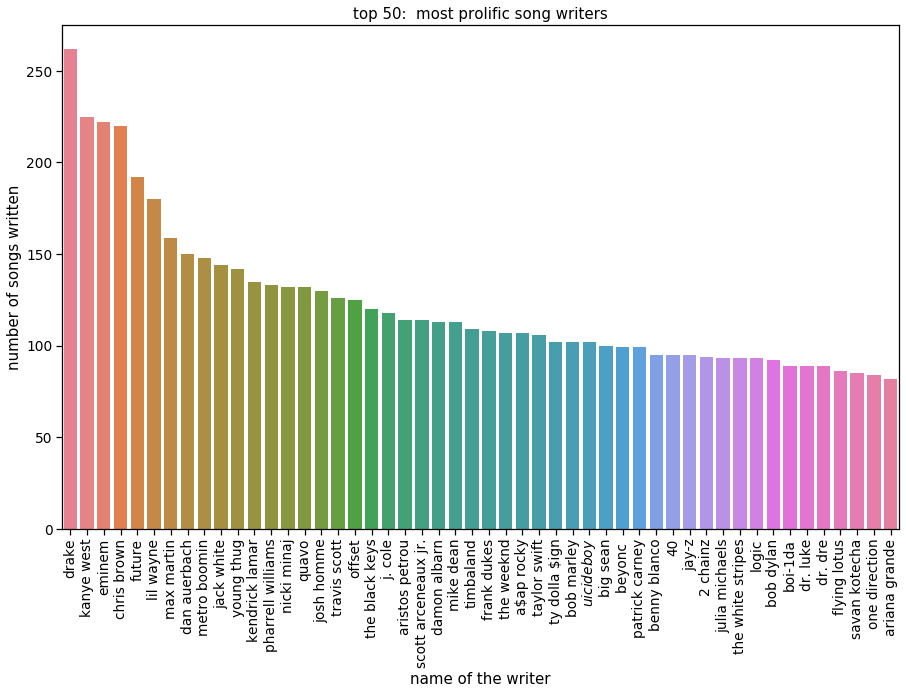

In [66]:
# creation of the list of all the songwriters in our dataframe
songwriters_list = []
for list_ in final_dataframe['songwriters'].values:
    for elem in list_:
        songwriters_list.append(elem)

# now lets count the number of occurences of each songwriter in our dataset
song_writers_dictionnary = dict(collections.Counter(songwriters_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(song_writers_dictionnary, 50, x_lab='name of the writer', y_lab='number of songs written', title=' most prolific song writers')

What we can do now for examples is looking at the songs that a non singer songwriter has written. What song a singer didn't wrote for him and even what successes reach the songs they worked on

In [67]:
def find_songs_for_given_person(df, column_of_interest, name):
    
    '''
    find the songs that a given person helped created
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer)
           name: name of the person we want to obtain informations about
    OUTPUT: list_of_songs: all the songs on which the person worked
    '''
    
    list_of_songs = []
    for row in df.iterrows():
        if name in row[1][column_of_interest]:
            to_append = (row[1]['track_name'], row[1]['artist_name'], row[1]['popularity'])
            list_of_songs.append(to_append)
    return list_of_songs

def print_artist_worked_with(list_of_songs, name, plot_artist_himself=True, n=50):
    
    '''
    plot all the artist which the person of interest worked with
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer/label
    '''
    
    dict_artists = {}
    for tup in list_of_songs:
        name_ = tup[1]
        if name_ in dict_artists.keys():
            dict_artists[name_] +=1
        else:
            dict_artists[name_] = 1
    
    if not(plot_artist_himself):        
        del dict_artists[name]
    
    if len(dict_artists) < n:
        n = -1
    plot_n_most_common_persons(dict_artists, n, x_lab= 'artists who worked with ' + name, \
                               y_lab='number of songs done together', title= 'number of songs done by artists with ' + name)
    
def print_more_popular_track(list_of_songs, name, n):
    
    '''
    Plot the most popular track (at the time of the pull) that the producer/writer worked on
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer/label
           n: the n most popular track you want to plot
    '''
    
    dict_popularity = {}
    for tup in list_of_songs:
        name_ = tup[1]
        track = tup[0]
        dict_popularity[track + ' by ' + name_] = tup[2]
        
    plot_n_most_common_persons(dict_popularity, n, x_lab= 'songs on which ' + name + ' worked', \
                               y_lab='popularity of the songs', title= 'more popular tracks from ' + name)
    
def study_actor(df, name, role, n=40,  plot_artist_himself=True):
    
    '''
    Full study of the work of a person place in the industry
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer or even label)
           name: name of the person/label we want to obtain informations about
    
    '''
    
    list_of_songs = find_songs_for_given_person(df, role, name)
    print_artist_worked_with(list_of_songs, name, plot_artist_himself= plot_artist_himself, n=n)
    print_more_popular_track(list_of_songs, name, n)

Here we are looking at the influence of the songwriters Max Martin on the industry. Has you can see he has worked on really popular tracks (like all the last album of Arianna Grande or the hit I want it that way from the Backstreet Boys).

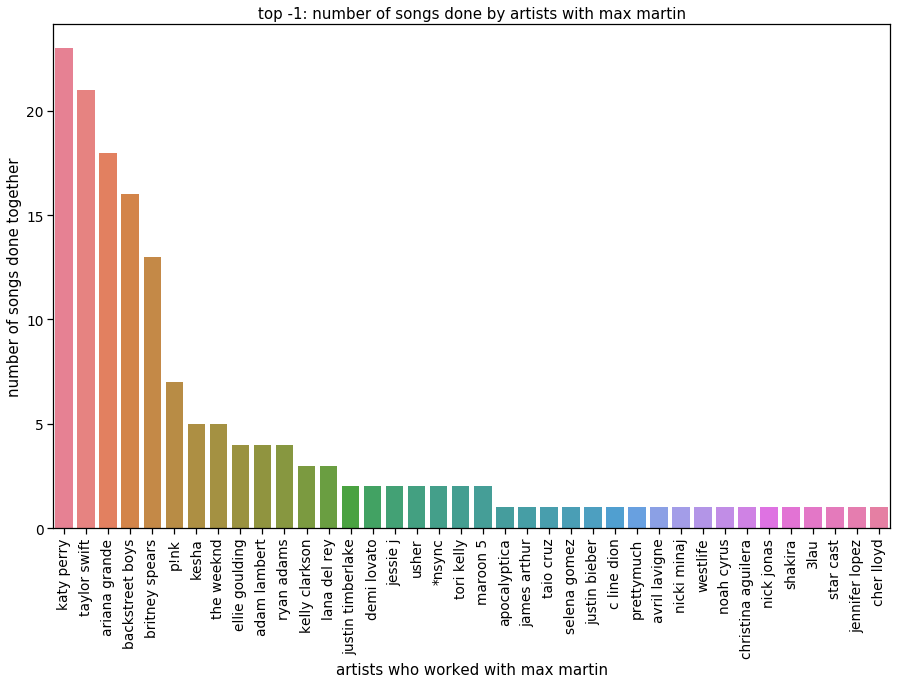

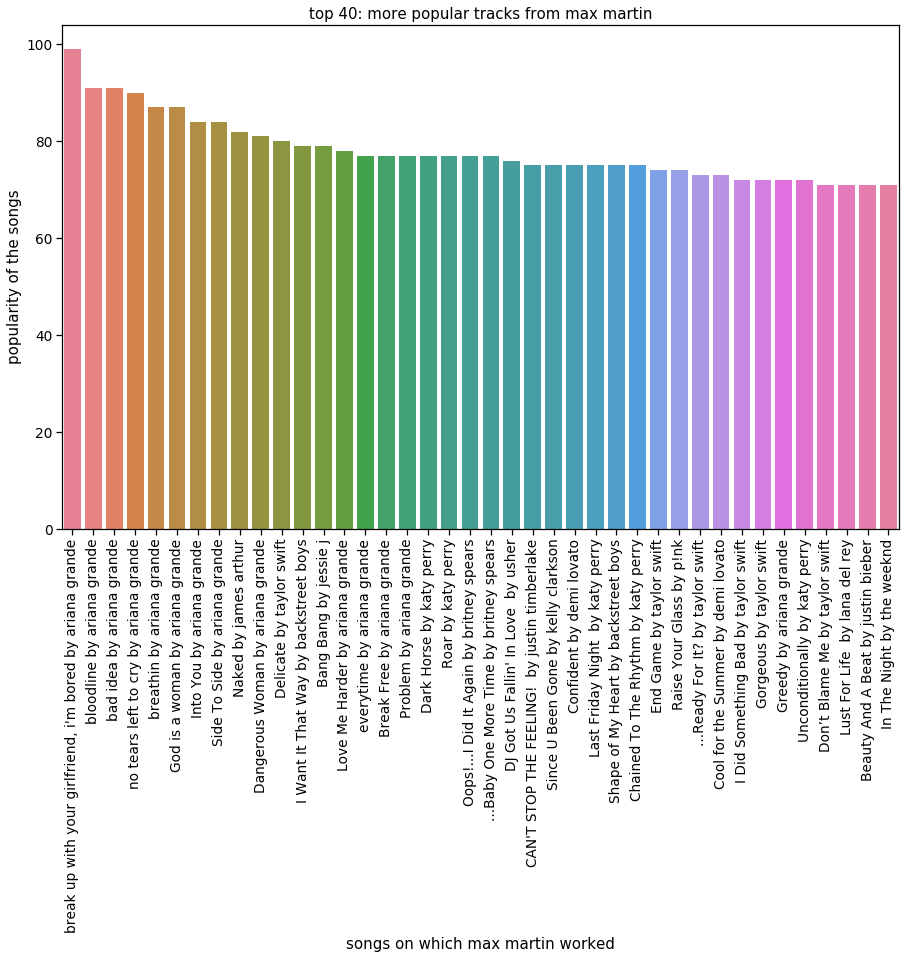

In [69]:
study_actor(final_dataframe, 'max martin', 'songwriters')

Now lets look at a well known songwriter as Ed Sheeran and let's study is place in the industry

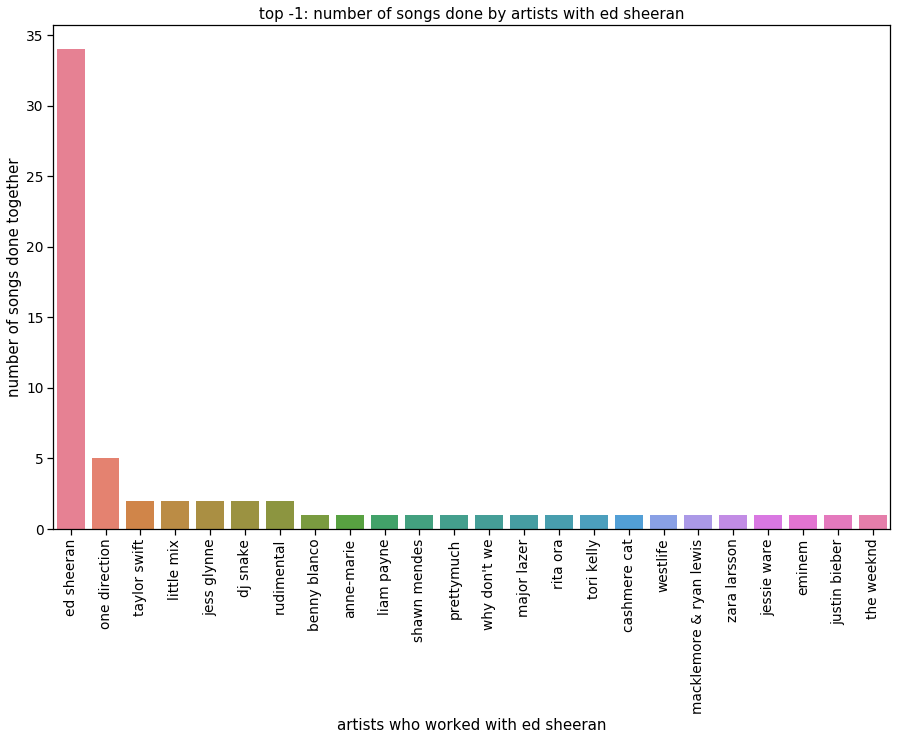

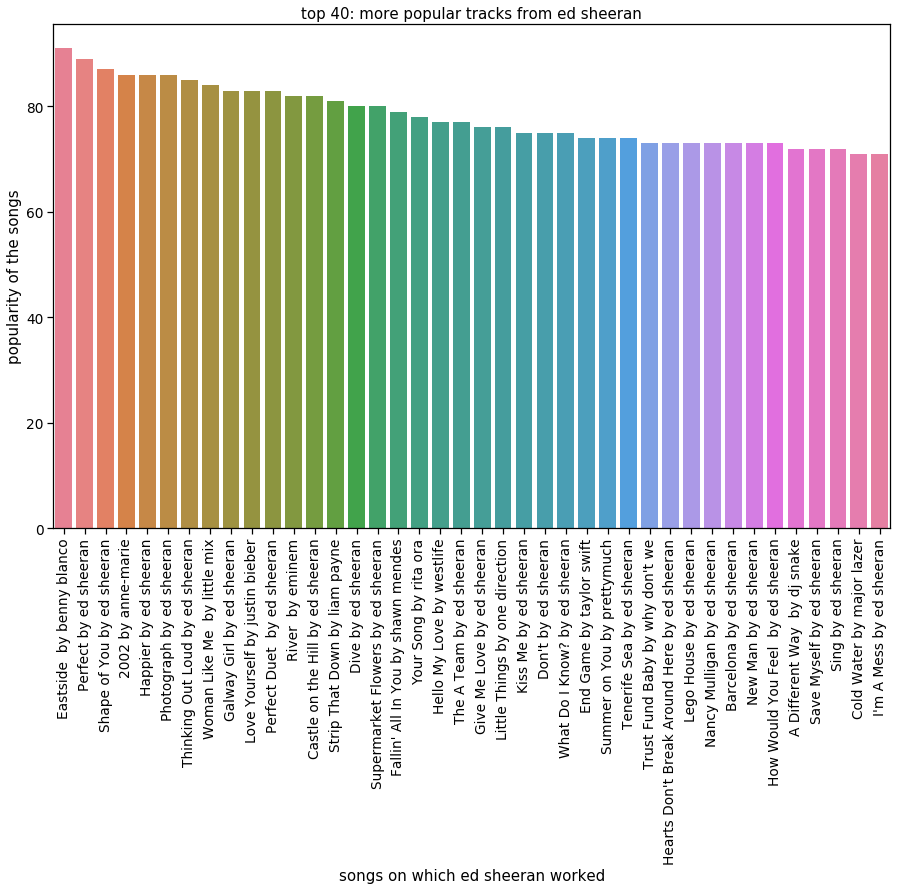

In [95]:
study_actor(final_dataframe, 'ed sheeran', 'songwriters')

### What about the labels ?

Now we wan look at what are the most represented labels in the dataset (remember that the label independent corresponds to people that didn't have any labels in the data and thus that we consider as people working on their own. We are going to drop them in this case so that our graph is more relevant)

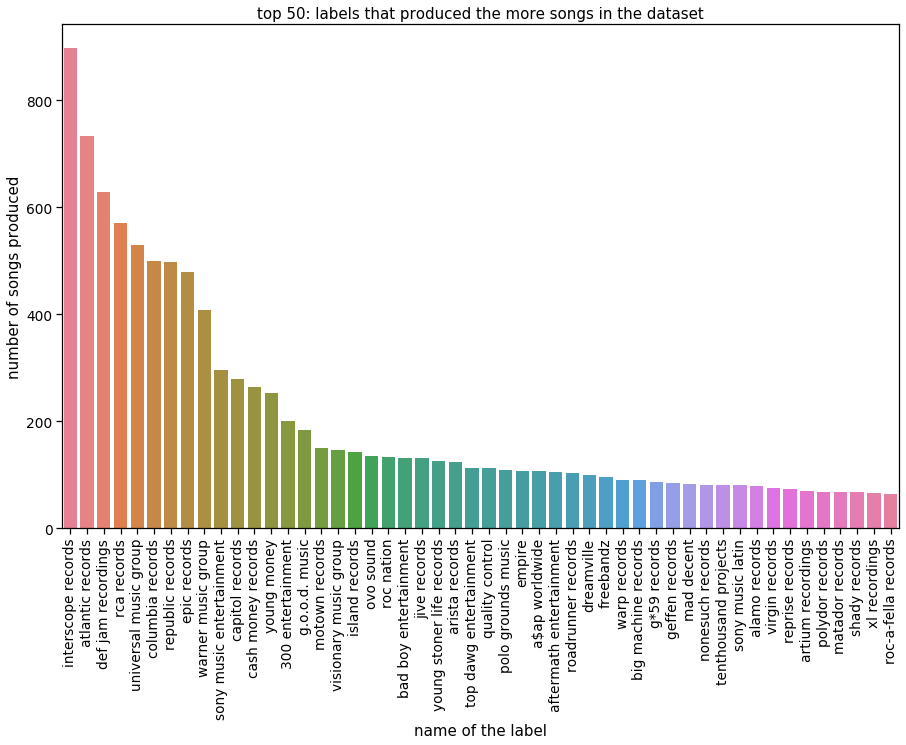

In [71]:
# creation of the list of all the labels in our dataframe
labels_list = []
for list_ in final_dataframe['labels'].values:
    for elem in list_:
        if elem != 'independent':
            labels_list.append(elem)

# now lets count the number of occurences of each labels in our dataset
labels_dictionnary = dict(collections.Counter(labels_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(labels_dictionnary, 50, x_lab='name of the label', y_lab='number of songs produced', title='labels that produced the more songs in the dataset')

Now we decided to just look into the label Atlantic Records. We will see which are the artists are the one with whom it worked the most and also what are the most popular (at the time of pulling) songs done with this label.

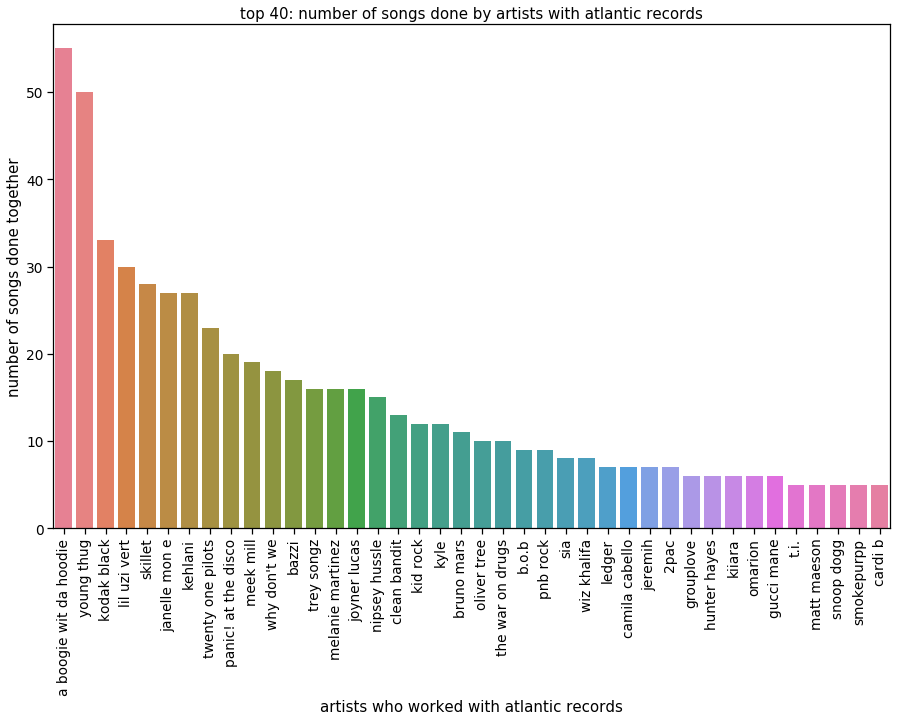

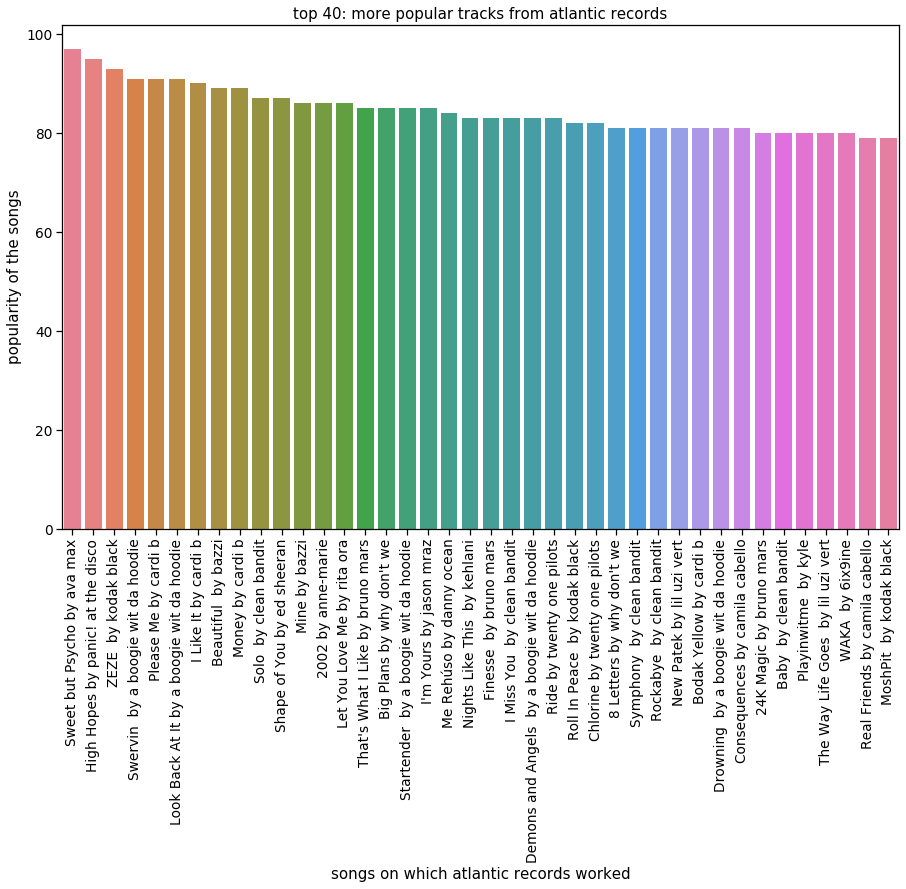

In [72]:
study_actor(final_dataframe, 'atlantic records', 'labels')

### What about the producers ?

Now that we have looked into both the songwriters and the labels, we will work on the producers. Note that we can imagine that lost of producers in this dataset are also songwriters. Thus we could have a graph similar to the one obtained for song writing.

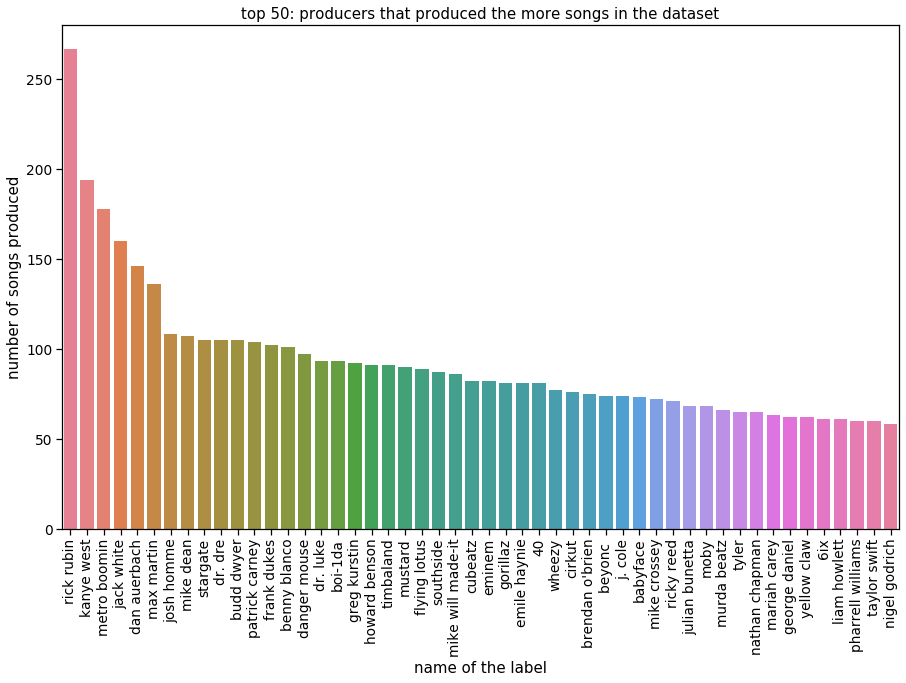

In [75]:
# creation of the list of all the producers in our dataframe
producers_list = []
for list_ in final_dataframe['producers'].values:
    for elem in list_:
        if elem != 'independent':
            producers_list.append(elem)

# now lets count the number of occurences of each producers in our dataset
producers_dictionnary = dict(collections.Counter(producers_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(producers_dictionnary, 50, x_lab='name of the label', y_lab='number of songs produced', title='producers that produced the more songs in the dataset')

This time, the first name appearing in the list is not a well known singer which is really interessting. Thus we are going to look into what Rick Rubin has done in the music industry.

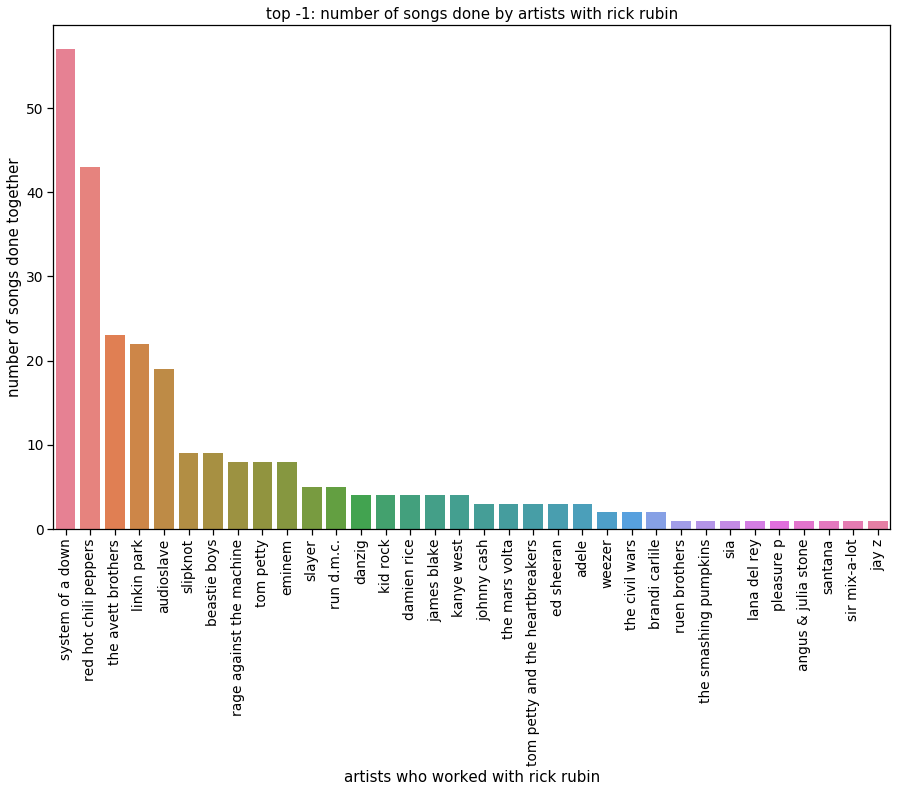

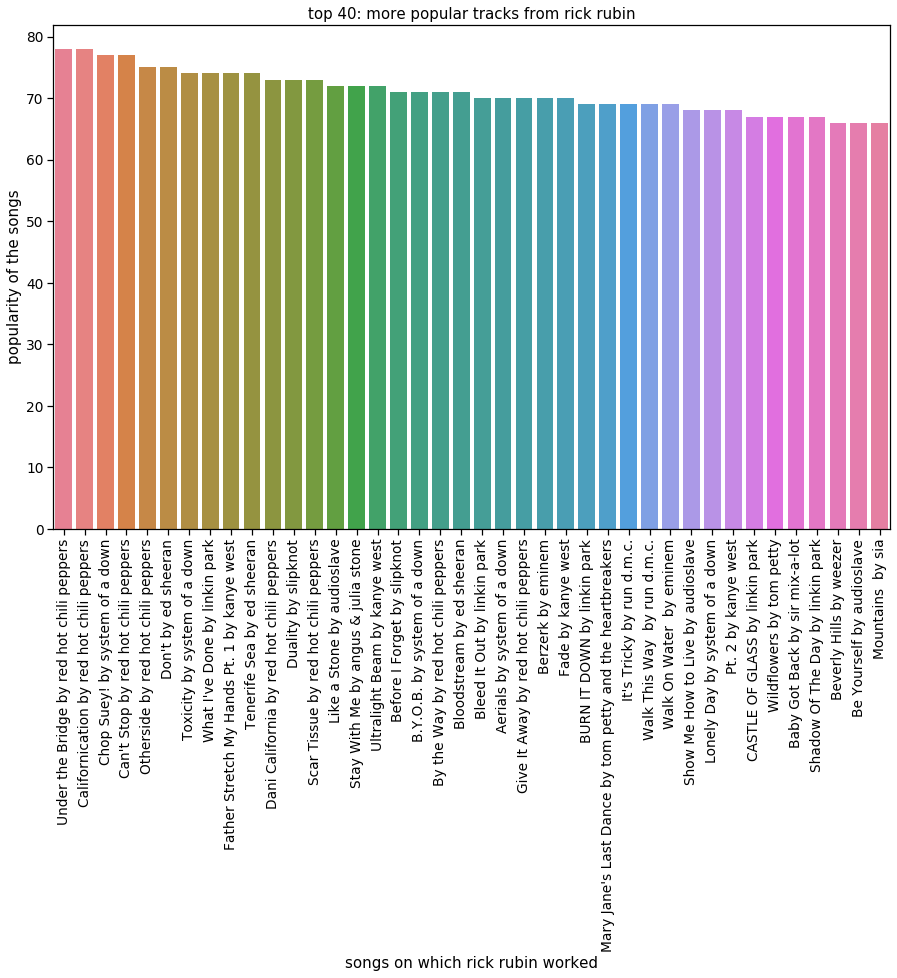

In [76]:
study_actor(final_dataframe, 'rick rubin', 'producers')

Here we can see that this producer mostly worked on the Rock/metal genres but some pops/raps song appear here and there. This could tell us that either our final graph will be fully connected and with only one giant connected component or that Rick Rubin could work as an HUB in a less connected graph.

**NOTE FOR GROUP:**  <span style="color:red"><em>If you can, try to do the same things but with genres of musics instead of artists and songs. This would mean redifine functions pretty similar to the one aboves but with some tweaks since we are only interessted in genre. Then plot them using plot_n_most_common_persons() which will still work in this case. </em> text</span>

## Preparation of the Adjacency matrix for future graph studies on the dataset

Now lets create the adjacency matrix corresponding to our notebook. To do so we first compute the total number of persons present in our dataset so that we know what the shape of the adjacency matrix will be

In [125]:
def create_list_of_persons(df):
    
    '''
    Given a dataframe create the list of persons present in the dataframe (list of all the singers/songwriters/producers)
    INPUT: df: dataframe containing persons
    OUTPUT: list_of_persons: set of all the persons contained in the dataframe
    '''
    
    # let's count the number of distinct person in the dataset
    list_of_persons = []

    for row in df.iterrows():
        artist = row[1]['artist_name']
        writers = row[1]['songwriters']
        producers = row[1]['producers']

        list_of_persons.append(artist)
        for name_ in writers:
            list_of_persons.append(str(name_))

        for name_ in producers:
            list_of_persons.append(str(name_))

    list_of_persons = set(list_of_persons)
    return list_of_persons

In [126]:
list_of_persons = create_list_of_persons(final_dataframe)

Let's create the adjacency matrix. We are gonna fill it in the following way:
1. Initialize the adjacency matrix as a 0s matrix
2. for each row in the dataframe:
    1. look at each person present in the row (artist + writers + producers)
    2. for each person creates edges going from one to another
    3. if the edge doesnt exist set the position in the matrix to 1
    4. else add one to the existing weight
    
We first define the functions that will help us create our adjacency matrix. Note that we also create an index dictionnary that associates to each name in the dataframe their index in the matrix.

In [135]:
def create_all_tuples(set_of_persons):
    
    '''
    given a set of persons, create all possible tuples of persons in the set
    INPUT: set_of_persons: a set of persons who worked on the same song
    OUTPUT: list_: list of all possible tuples
    '''
    
    set_of_persons = list(set_of_persons)
    list_ = [(set_of_persons[i],set_of_persons[j]) for i in range(len(set_of_persons)) for j in range(i+1, len(set_of_persons))]
    return list_

def create_adjacency(df, shape):
    
    '''
    Given a dataframe containing artists, songwriters and producers, create the adjacency matrix such that two persons that
    worked together on the same songs are linked by an edge.
    INPUT: df: music dataframe containing our singers/songwriters/producers
           shape: shape of the adjacency matrix we want to create
    OUTPUT: adjacency: numpy array, the adjacency matrix representing the working relationships present in the dataset
            nodes_dictionnary: dictionnay that associates each index in the adjacency matrix to the corresponding person in the 
                               dataset
    '''
    
    adjacency = np.zeros(shape)
    nodes_dictionnary = {}
    
    idx = 0
    for row in df.iterrows():
        artist = row[1]['artist_name']
        writers = row[1]['songwriters']
        producers = row[1]['producers']

        persons_in_row = np.concatenate(([artist], writers, producers), axis=None)
        persons_in_row = set(persons_in_row)
        
        if len(persons_in_row) == 1:
            name = list(persons_in_row)[0]
            if name not in nodes_dictionnary.keys():
                nodes_dictionnary[list(persons_in_row)[0]] = idx
                idx +=1
        else:
            
            list_of_tuples = create_all_tuples(persons_in_row)


            for tup in list_of_tuples:
                node_1 = tup[0]
                node_2 = tup[1]

                if node_1 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_1] = idx
                    idx +=1

                if node_2 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_2] = idx
                    idx +=1

                i = nodes_dictionnary[node_1]
                j = nodes_dictionnary[node_2]

                adjacency[i][j] += 1
                adjacency[j][i] += 1
    
    return adjacency, nodes_dictionnary

def check_adjacency(list_of_persons, nodes_dictionnary):
    
    '''
    Function that allow us to check if our adjacency was well constructed.
    INPUT: list_of_persons: list of all persons that we need to find in the nodes dictionnary
           nodes_dictionnary: dictionnary containing all the ids corresponding to the persons in the list_of_persons
    OUTPUT: bool_: boolean; True if some people were missed while creating the adjacency else False
            list_of_missed: list of people that we missed when creating the adjacency
    '''
    
    list_of_missed = []
    bool_ = False
    for elem in list_of_persons:
        if elem not in nodes_dictionnary.keys():
            list_of_missed.append(elem)
            
    if len(list_of_missed) != 0:
        bool_ = True
        
    return bool_, list_of_missed

Let's compute the adjacency matrix and the dictionnary of nodes from our dataframe.

In [137]:
# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_persons)
shape = (len_, len_)

adjacency, nodes_dictionnary = create_adjacency(final_dataframe, shape)
# check either our adjacency was well created or not
check_adjacency(list_of_persons, nodes_dictionnary)

(False, [])